<a href="https://colab.research.google.com/github/brianmanderson/Image_Prediction/blob/main/BMAPredictionWork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# pix2pix: Image-to-image translation with a conditional GAN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/pix2pix"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/pix2pix.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/pix2pix.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/pix2pix.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This Google Colab Notebook heavily buroows from the pix2pix example. 
How to build and train a conditional generative adversarial network (cGAN) called pix2pix that learns a mapping from input images to output images, as described in [Image-to-image translation with conditional adversarial networks](https://arxiv.org/abs/1611.07004) by Isola et al. (2017). pix2pix is not application specific—it can be applied to a wide range of tasks, including synthesizing photos from label maps, generating colorized photos from black and white images, turning Google Maps photos into aerial images, and even transforming sketches into photos.

In the pix2pix cGAN, you condition on input images and generate corresponding output images. cGANs were first proposed in [Conditional Generative Adversarial Nets](https://arxiv.org/abs/1411.1784) (Mirza and Osindero, 2014)

The architecture of your network will contain:

- A generator with a [U-Net]([U-Net](https://arxiv.org/abs/1505.04597))-based architecture.
- A discriminator represented by a convolutional PatchGAN classifier (proposed in the [pix2pix paper](https://arxiv.org/abs/1611.07004)).

Note that each epoch can take around 15 seconds on a single V100 GPU.



## Import TensorFlow and other libraries

In [1]:
import tensorflow as tf
import pandas as pd
import time
import os
import sys 
import pathlib
import time
import datetime
import numpy as np
from matplotlib import pyplot as plt
from IPython import display
import tensorflow.experimental.numpy as tnp

In [2]:
running_local = False
try:
    from google.colab import drive
    drive.mount('/content/drive')
    nb_path = '/content/notebooks'
    os.symlink('/content/drive/MyDrive/Colab Notebooks', nb_path)
    sys.path.insert(0, nb_path)  # or append(nb_path)
except:
    running_local = True
    print("Running locally")

Mounted at /content/drive


Line to install pymedphys which has a gamma function. Libaray was saved to Google drive and is commented out.

In [4]:
#!pip install --target=$nb_path pymedphys

In [3]:
!pip install SimpleITK
!pip install pymedphys
!pip install PlotScrollNumpyArrays

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48.4 MB 1.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 14.4 MB/s 
     |████████████████████████████████| 793 kB 60.2 MB/s 
     |████████████████████████████████| 381 kB 64.0 MB/s 
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: ipython
    Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
#import SimpleITK as sitk
import pymedphys

In [5]:
!git clone --recurse-submodules -j8 https://github.com/brianmanderson/Data_Generators

Cloning into 'Data_Generators'...
remote: Enumerating objects: 1094, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 1094 (delta 44), reused 67 (delta 25), pack-reused 1006
Receiving objects: 100% (1094/1094), 524.55 KiB | 15.43 MiB/s, done.
Resolving deltas: 100% (690/690), done.
Submodule 'Image_Processors_Module' (https://github.com/brianmanderson/Image_Processors_Module.git) registered for path 'Image_Processors_Module'
Cloning into '/content/Data_Generators/Image_Processors_Module'...
remote: Enumerating objects: 1271, done.        
remote: Counting objects: 100% (66/66), done.        
remote: Compressing objects: 100% (25/25), done.        
remote: Total 1271 (delta 36), reused 58 (delta 29), pack-reused 1205        
Receiving objects: 100% (1271/1271), 294.66 KiB | 8.67 MiB/s, done.
Resolving deltas: 100% (809/809), done.
Submodule path 'Image_Processors_Module': checked out '23dae05326dc1d320f4fa56c9163fe4a994aa

In [6]:
from Data_Generators.TFRecord_to_Dataset_Generator import DataGeneratorClass
from Data_Generators.Image_Processors_Module.src.Processors.TFDataSets import ConstantProcessors as CProcessors,\
    RelativeProcessors as RProcessors

In [7]:
class ImageProcessor(object):
    def parse(self, *args, **kwargs):
        return args, kwargs
def _check_keys_(input_features, keys):
    if type(keys) is list or type(keys) is tuple:
        for key in keys:
            assert key in input_features.keys(), 'Make sure the key you are referring to is present in the features, ' \
                                                 '{} was not found'.format(key)
    else:
        assert keys in input_features.keys(), 'Make sure the key you are referring to is present in the features, ' \
                                              '{} was not found'.format(keys)
class DivideBasedOnOther(ImageProcessor):
    def __init__(self, guiding_keys=('annotation',), changing_keys=('image',)):
        self.guiding_keys, self.changing_keys = guiding_keys, changing_keys

    def parse(self, input_features, *args, **kwargs):
        _check_keys_(input_features=input_features, keys=self.guiding_keys)
        _check_keys_(input_features=input_features, keys=self.changing_keys)
        for guiding_key, changing_key in zip(self.guiding_keys, self.changing_keys):
            input_features[changing_key] = input_features[changing_key] / input_features[guiding_key]
        return input_features

Pull a sample image.   There are 4 images in 1 that need to be reformatted. From left to right, ray trace projection of CBCT. Fluence Map, PDOS and RTImage

In [7]:
def return_generator(records_path, proj_to_panel=True, add_5cm_keys=True, **kwargs):
  global_norm = False
  generator = DataGeneratorClass(record_paths=records_path, delete_old_cache=True)
  all_keys = ('pdos_array', 'fluence_array','drr_array', 'deep_to_panel_array', 'iso_to_panel_array', 'shallow_to_panel_array')
  drr_keys = ('drr_array', 'deep_to_panel_array', 'iso_to_panel_array', 'shallow_to_panel_array', )
  input_keys = ('pdos_array', 'drr_array', 'iso_to_panel_array')
  if add_5cm_keys:
    if proj_to_panel:
      input_keys = ('pdos_array', 'drr_array', 'deep_to_panel_array', 'iso_to_panel_array',
                    'shallow_to_panel_array')
    else:
      input_keys = ('pdos_array', 'drr_array', '5cm_deep_array', 'iso_array', 'shallow_array')
  print(f"Inputs are {input_keys}")
  base_processors = [
                     CProcessors.Squeeze(image_keys=all_keys),
                     CProcessors.ExpandDimension(axis=-1, image_keys=all_keys),
                     CProcessors.MultiplyImagesByConstant(keys=drr_keys,
                                                          values=(1/90, 1/90, 1/90, 1/90)),
                     ]
  if global_norm:
    base_processors += [
                        CProcessors.MultiplyImagesByConstant(keys=('pdos_array',
                                                                'fluence_array'),
                                                             values=(1, 1)) #(1/2, 1/(.3876*2))
                        ]
  else:
    base_processors += [
                        RProcessors.NormalizeBasedOnOther(guiding_keys=('pdos_array', 'pdos_array'),
                                                          changing_keys=('fluence_array', 'pdos_array'),
                                                          reference_method=('reduce_max', 'reduce_max'),
                                                          changing_methods=('divide', 'divide'))
                        ]
  base_processors += [
                      CProcessors.CombineKeys(axis=-1,
                                              image_keys=input_keys,
                                              output_key='output'),
                      CProcessors.ReturnOutputs(input_keys=('output',),
                                                output_keys=('fluence_array',))
  ]
  base_processors += [
                      {'batch': 1}, {'repeat'}
                      ]
  generator.compile_data_set(image_processors=base_processors, debug=False)
  return generator

In [8]:
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [9]:
def load_data_from_generator(generator):
  data = {'input' : [], 'rtimg' : []}
  iterator = iter(generator.data_set)
  for _ in range(len(generator)):
    x, y = next(iterator)
    data['input'].append(x[0][0])
    data['rtimg'].append(y[0][0])
  return data

# Return a train and validation dataset based on which fold you want to exclude

In [10]:
def return_datasets(data_generators):
  all_datasets = {}
  for i in data_generators.keys():
    generator = data_generators[i]
    all_datasets[i] = tf.data.Dataset.from_tensor_slices((load_data_from_generator(generator)))
  return all_datasets

def return_fold_datasets(data_generators, batch_size=1):
  all_datasets = return_datasets(data_generators)

  train_dataset = all_datasets['train']
  train_dataset = train_dataset.shuffle(len(train_dataset))
  train_dataset = train_dataset.batch(batch_size)
  
  valid_dataset = all_datasets['validation']
  #valid_dataset = valid_dataset.shuffle(len(valid_dataset))
  valid_dataset = valid_dataset.batch(1)
  return train_dataset, valid_dataset

In [11]:
def return_dataset(generator, batch):
  input_values = []
  output_values = []
  iterator = iter(generator.data_set)
  for _ in range(len(generator)):
    x, y = next(iterator)
    input_values.append(x[0][0])
    output_values.append(y[0][0])
  input_dataset = tf.data.Dataset.from_tensor_slices(input_values)
  output_dataset = tf.data.Dataset.from_tensor_slices(output_values)
  dataset = tf.data.Dataset.zip((input_dataset, output_dataset))
  dataset = dataset.shuffle(len(dataset)).batch(batch)
  return dataset

In [12]:
def return_generators(base_path, excluded_fold=5, batch=1, **kwargs):
  data_generators = {}
  train_folder_names = []
  val_folder_names = []
  train_folder_names.append(os.path.join(base_path, 'phantom_train'))
  val_folder_names.append(os.path.join(base_path, 'phantom_valid'))
  #for i in range(1,6):
    #folder_name = '/content/drive/My Drive/data/fold{}'.format(i)
    #if i != excluded_fold:
      #train_folder_names.append(folder_name)
    #else:
      #val_folder_names.append(folder_name)
  train_gen = return_generator(train_folder_names, batch=1, **kwargs)
  train_gen = return_dataset(train_gen, batch)

  valid_gen = return_generator(val_folder_names, batch=1, **kwargs)
  valid_gen = return_dataset(valid_gen, 1)
  return train_gen, valid_gen

In [40]:
batch = 24
base_path = '/content/drive/My Drive/data'
train_dataset, valid_dataset = return_generators(base_path, excluded_fold=1, batch=batch)

Inputs are ('pdos_array', 'drr_array', 'deep_to_panel_array', 'iso_to_panel_array', 'shallow_to_panel_array')
{'batch': 1}
{'repeat'}
Inputs are ('pdos_array', 'drr_array', 'deep_to_panel_array', 'iso_to_panel_array', 'shallow_to_panel_array')
{'batch': 1}
{'repeat'}


In [41]:
iterx = iter(train_dataset.repeat())

9
83


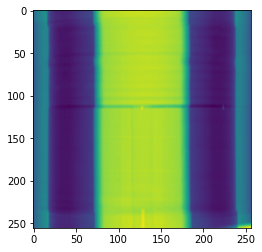

In [42]:
len(train_dataset)
x, y = next(iterx)
print(len(train_dataset))
print(len(valid_dataset))
plt.imshow(x[0,...,3])

In [ ]:
def resample_array(numpy_array, distance_wanted=1000, acquired_distance=1540):
  x = tf.convert_to_tensor(numpy_array)
  current_size = x.shape[1]
  output_size = int(x.shape[1]//2*distance_wanted/acquired_distance*2)
  new_image = tf.image.resize(x, [output_size, output_size])
  if current_size > output_size:
    new_image = tf.image.pad_to_bounding_box(new_image, (current_size-output_size)//2, (current_size-output_size)//2, current_size, current_size)
  else:
    new_image = new_image[:, abs(current_size - output_size)//2:-abs(current_size - output_size)//2,abs(current_size - output_size)//2:-abs(current_size - output_size)//2]
  return new_image.numpy()

In [ ]:
plt.imshow(x[0,...,1])

In [ ]:
ratio_drr_minus5 = []
ratio_drr_iso = []
ratio_drr_plus5 = []
ratio_drr_minus5.append(x[0][0, 125, 125, 2]/x[0][0, 125, 125, 1])
ratio_drr_iso.append(x[0][0, 125, 125,3]/x[0][0, 125, 125, 2])
ratio_drr_plus5.append(x[0][0,125, 125,4]/x[0][0,125, 125,3])

In [ ]:
x[:, 125, 125, 0] * np.exp(-x[:, 125, 125, 1])/y[:, 125, 125, 0]

In [ ]:
ratio_drr_minus5 = []
ratio_drr_iso = []
ratio_drr_plus5 = []
for i in range(len(valid_dataset)):
  x, y = next(iterx)
  ratio_drr_minus5.append(x[0, 125, 125, 2]/x[0, 125, 125, 1])
  ratio_drr_iso.append(x[0, 125, 125,3]/x[0, 125, 125, 2])
  if x[0, 125, 125,3]/x[0, 125, 125, 2] > 100:
    print(i)
    break
  ratio_drr_plus5.append(x[0,125, 125,4]/x[0,125, 125,3])

In [ ]:
plt.imshow(x[0,...,4])

In [ ]:
print(np.max(x[...,0].numpy()))
print(np.max(x[...,1].numpy()))
print(np.max(x[...,2].numpy()))
print(np.max(x[...,3].numpy()))
print(np.max(x[...,4].numpy()))
print(np.max(y.numpy()))

In [ ]:
fluences = []
pdoses = []
drrs = []
isos = []
minus5 = []
plus5 = []
iterx = iter(data_generators['train'].data_set)
for i in range(len(train_dataset)):
  x, y = next(iterx)
  fluences.append(np.max(y.numpy()))
  pdoses.append(np.max(x[...,0].numpy()))
  drrs.append(np.mean(x[..., 1].numpy()))
  isos.append(np.mean(x[..., 2].numpy()))
  minus5.append(np.mean(x[..., 3].numpy()))
  plus5.append(np.mean(x[..., 4].numpy()))

In [ ]:
y[0, 128, 128]

In [ ]:
1/0.011

In [ ]:
x[0, 128, 128, 0]*np.exp(-x[0, 128, 128, 4]*1/35)/y[0, 128, 128]

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist([i/1 for i in drrs], bins=25)
# plt.hist([i/1 for i in isos], bins=25)
# plt.hist([i/1 for i in minus5], bins=25)
# plt.hist([i/1 for i in plus5], bins=25)

In [ ]:
print(f"Fluence mean is {np.mean(fluences)}")
print(f"Fluence std is {np.std(fluences)}")
print(f"Pdos mean is {np.mean(pdoses)}")
print(f"Pdos std is {np.std(pdoses)}")
print(f"DRR mean is {np.mean(drrs)}")
print(f"DRR std is {np.std(drrs)}")

In [ ]:
def getinput(input_image,chan):
    slice_image = input_image[:,:,chan]
    slice_image = tf.cast(slice_image, tf.float32)
    return slice_image

In [ ]:
plt.imshow(y[0,...,0])

As described in the [pix2pix paper](https://arxiv.org/abs/1611.07004), you need to apply random jittering and mirroring to preprocess the training set.

Define functions that:

1. Randomly flip the image horizontally i.e. left to right (random mirroring).
2. Normalize the images to the `[-1, 1]` range. 

You can inspect some of the preprocessed output:

In [13]:
def downsampleBMA(x, filters, size, apply_batchnorm=True, basic=False):
  initializer = tf.random_normal_initializer(0., 0.02)
  if basic:
    x = tf.keras.layers.MaxPool2D()(x)
  else:
    x = tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                               kernel_initializer=initializer, use_bias=True)(x)

    if apply_batchnorm:
      x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
  return x

In [14]:
def upsampleBMA(x, filters, size, apply_dropout=False, basic=False):
  initializer = tf.random_normal_initializer(0., 0.02)
  if basic:
    x = tf.keras.layers.UpSampling2D()(x)
  else:
    x =  tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         use_bias=True)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    if apply_dropout:
      x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.LeakyReLU()(x)
  return x

In [15]:
def convlayerBMA(x, filters, size, apply_batchnorm=True):
  x = tf.keras.layers.Conv2D(filters, size, strides=1, padding='same',
                             use_bias=True)(x)

  if apply_batchnorm:
    x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ELU()(x)
  return x

Define the upsampler (decoder):

In [16]:
def ReturnUNet(x, size=4, layers=7, filters_start=64, double_layers=4):
  """
  default values creates the original generator, filters double from start
  to a max after the number of 'double layers'
  Size is the kernel size
  Layers is the number of layers
  """
  filters_list = []
  for _ in range(double_layers):
    filters_list.append(filters_start)
    filters_start *= 2
  up_filters = []
  batchnorm = False
  down_stack = []
  for _ in range(layers):
    if filters_list:
      filters = filters_list.pop(0)
    up_filters.append(filters)
    x = downsampleBMA(x, filters, size, batchnorm)
    batchnorm = True
    down_stack.append(x)
  x = downsampleBMA(x, filters, size, batchnorm)
  for _ in range(layers):
    filters = up_filters.pop()
    skip = down_stack.pop()
    apply_dropout = False
    x = upsampleBMA(x, filters, size, apply_dropout=apply_dropout)
    x = tf.keras.layers.Concatenate()([x, skip])
  x = upsampleBMA(x, filters, size, apply_dropout=apply_dropout)
  return x

In [17]:
def resize_tensor(x, wanted_distance=1000, acquired_distance=1540):
  output_size = int(x.shape[1]//2*wanted_distance/acquired_distance*2)
  current_size = x.shape[1]
  x = tf.image.resize(x, [output_size, output_size])
  if wanted_distance < acquired_distance:
    x = tf.image.pad_to_bounding_box(x, (current_size - output_size) // 2,
                                      (current_size - output_size) // 2, current_size, current_size)
  else:
    x = x[:, (output_size-current_size)//2:-(output_size-current_size)//2,
        (output_size-current_size)//2:-(output_size-current_size)//2]
  return x

In [18]:
def GeneratorBMA2Old(top_layers=2, size=4, layers=7, filters_start=64, double_layers=4, add_unet=False, max_filters=64, add_5cm_keys=True, **kwargs):
  """
  Default generator from model index 0-9
  """
  inputs = x = tf.keras.layers.Input(shape=[256, 256, 3])
  if add_5cm_keys:
    inputs = x = tf.keras.layers.Input(shape=[256, 256, 5])
  PDOS = tf.expand_dims(inputs[..., 0], axis=-1, name='PDOS')
  fulldrr = tf.expand_dims(inputs[..., 1], axis=-1)
  deep_to_panel = tf.expand_dims(inputs[..., 2], axis=-1)
  iso_to_panel = tf.expand_dims(inputs[..., 3], axis=-1)
  drr_shallow_to_panel = tf.expand_dims(inputs[..., 4], axis=-1)

  fluence_shallow_to_panel = tf.math.exp(-convlayerBMA(drr_shallow_to_panel, filters_start, size)) * PDOS
  #fluence_shallow_to_panel = resize_tensor(fluence_shallow, wanted_distance=1540, acquired_distance=950)
  #fluence_to_iso = resize_tensor(fluence_shallow, wanted_distance=1000, acquired_distance=950)
  
  #drr_dif_iso_and_shallow = tf.keras.layers.ReLU()(iso_drr - resize_tensor(drr_shallow, wanted_distance=1000, acquired_distance=950))
  fluence_iso_to_panel = tf.math.exp(-convlayerBMA(iso_to_panel, filters_start, size)) * PDOS
  # fluence_iso_to_panel = resize_tensor(fluence_iso, wanted_distance=1540, acquired_distance=1000)
  #fluence_to_deeper = resize_tensor(fluence_iso, wanted_distance=1050, acquired_distance=1000)
  #drr_dif_deeper_and_iso = tf.keras.layers.ReLU()(drr_deep - resize_tensor(iso_drr, wanted_distance=1050, acquired_distance=1000))
  fluence_deep_to_panel = tf.math.exp(-convlayerBMA(deep_to_panel, filters_start, size)) * PDOS
  # fluence_deeper_to_panel = resize_tensor(fluence_deeper, wanted_distance=1540, acquired_distance=1050)

  #drr_dif_panel_and_deeper = tf.keras.layers.ReLU()(fulldrr - resize_tensor(drr_deep, wanted_distance=1540, acquired_distance=1050))
  fluence_panel = tf.math.exp(-convlayerBMA(fulldrr, filters_start, size)) * PDOS

  x = tf.keras.layers.Concatenate()([fluence_shallow_to_panel, fluence_iso_to_panel, fluence_deep_to_panel, fluence_panel])
  filters_start *= 4
  x = convlayerBMA(x, min([filters_start, max_filters]), size)
  for _ in range(top_layers):
    filters_start *= 2
    x = convlayerBMA(x, min([filters_start, max_filters]), size)
  if add_unet:
    base_out = x
    x = ReturnUNet(x=x, size=size, layers=layers, filters_start=min([filters_start, max_filters]), double_layers=double_layers)
    x = tf.keras.layers.Concatenate()([x, base_out])
  x = tf.keras.layers.Concatenate()([x, fluence_panel])
  x = convlayerBMA(x, min([filters_start, max_filters]), size)
  x = tf.keras.layers.Conv2D(filters=1, kernel_size=1, activation=None,
                             padding='same', use_bias=True)(x)
  return tf.keras.Model(inputs=inputs, outputs=x)


In [19]:
def GeneratorBMA2(top_layers=2, size=4, layers=7, filters_start=64, double_layers=4, add_unet=False, max_filters=64, add_5cm_keys=True, **kwargs):
  """
  default values creates the original generator, filters double from start
  to a max after the number of 'double layers'
  Size is the kernel size
  Layers is the number of layers
  """
  """
  Back to basic physics
  """
  filters = filters_start
  if add_5cm_keys:
    inputs = x = tf.keras.layers.Input(shape=[256, 256, 5])
    deep_to_panel = tf.expand_dims(inputs[..., 2], axis=-1)
    iso_to_panel = tf.expand_dims(inputs[..., 3], axis=-1)
    drr_shallow_to_panel = tf.expand_dims(inputs[..., 4], axis=-1)
  else:
    inputs = x = tf.keras.layers.Input(shape=[256, 256, 3])
    iso_to_panel = tf.expand_dims(inputs[..., 2], axis=-1)
  PDOS = tf.expand_dims(inputs[..., 0], axis=-1, name='PDOS')
  fulldrr = tf.expand_dims(inputs[..., 1], axis=-1)
  """
  First, pass along the iso to panel, and full drr to panel
  """
  fluence_iso_to_panel = tf.math.exp(-convlayerBMA(iso_to_panel, filters, size)) * PDOS
  fluence_panel = tf.math.exp(-convlayerBMA(fulldrr, filters, size)) * PDOS
  """
  Next, add in the shallow and deep
  """
  if add_5cm_keys:
    fluence_shallow_to_panel = tf.math.exp(-convlayerBMA(drr_shallow_to_panel, filters, size)) * PDOS
    fluence_deep_to_panel = tf.math.exp(-convlayerBMA(deep_to_panel, filters, size)) * PDOS
  #fluence_shallow_to_panel = resize_tensor(fluence_shallow, wanted_distance=1540, acquired_distance=950)
  #fluence_to_iso = resize_tensor(fluence_shallow, wanted_distance=1000, acquired_distance=950)
  
  #drr_dif_iso_and_shallow = tf.keras.layers.ReLU()(iso_drr - resize_tensor(drr_shallow, wanted_distance=1000, acquired_distance=950))

  # fluence_iso_to_panel = resize_tensor(fluence_iso, wanted_distance=1540, acquired_distance=1000)
  #fluence_to_deeper = resize_tensor(fluence_iso, wanted_distance=1050, acquired_distance=1000)
  #drr_dif_deeper_and_iso = tf.keras.layers.ReLU()(drr_deep - resize_tensor(iso_drr, wanted_distance=1050, acquired_distance=1000))
  
  # fluence_deeper_to_panel = resize_tensor(fluence_deeper, wanted_distance=1540, acquired_distance=1050)

  #drr_dif_panel_and_deeper = tf.keras.layers.ReLU()(fulldrr - resize_tensor(drr_deep, wanted_distance=1540, acquired_distance=1050))
  
  if add_5cm_keys:
    x = tf.keras.layers.Concatenate()([fluence_shallow_to_panel, fluence_iso_to_panel, fluence_deep_to_panel, fluence_panel])
  else:
    x = tf.keras.layers.Concatenate()([fluence_iso_to_panel, fluence_panel])
  filters *= 2
  x = convlayerBMA(x, min([filters, max_filters]), size)
  for _ in range(top_layers):
    filters *= 2
    x = convlayerBMA(x, min([filters, max_filters]), size)
  if add_unet:
    base_out = x
    x = ReturnUNet(x=x, size=size, layers=layers, filters_start=filters_start, double_layers=double_layers)
    x = tf.keras.layers.Concatenate()([x, base_out])
  x = tf.keras.layers.Concatenate()([x, fluence_panel])
  x = convlayerBMA(x, min([filters, max_filters]), size)
  x = tf.keras.layers.Conv2D(filters=1, kernel_size=1, activation=None,
                             padding='same', use_bias=True)(x)
  return tf.keras.Model(inputs=inputs, outputs=x)


Define the generator with the downsampler and the upsampler:

In [20]:
def GeneratorBMA(size=4, layers=7, filters_start=64, double_layers=4):
  """
  default values creates the original generator, filters double from start
  to a max after the number of 'double layers'
  Size is the kernel size
  Layers is the number of layers
  """
  """
  Back to basic physics
  """
  inputs = x = tf.keras.layers.Input(shape=[256, 256, 5])
  x = ReturnUNet(x=x, size=size, layers=layers, filters_start=filters_start, double_layers=double_layers)
  x =  tf.keras.layers.Conv2DTranspose(1, size, strides=2, padding='same', activation=None,
                                       kernel_initializer=tf.random_normal_initializer(0., 0.02))(x)
  return tf.keras.Model(inputs=inputs, outputs=x)


In [ ]:
generator = GeneratorBMA2(top_layers=2, size=4, layers=2, filters_start=16, double_layers=4, add_unet=True, max_filters=16)
# generator = GeneratorBMA()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=75)

Visualize the generator model architecture:

In [ ]:
#tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)
generator.summary()

In [ ]:
generator = GeneratorBMA2(add_unet=False, add_half=True)
generator.layers[-2].weights

In [ ]:
previous_output = "/content/drive/MyDrive/Colab Notebooks/BMAlogs/phantom/named"
previous_model_path = os.path.join(previous_output, 'final_model.h5')
generatornew = Generator(size=kernel, layers=3, filters_start=filters, double_layers=4)
generatornew.load_weights(previous_model_path, by_name=True)

In [ ]:
def load_and_freeze_weights(model):
  previous_output = "/content/drive/MyDrive/Colab Notebooks/BMAlogs/phantom/named"
  previous_model_path = os.path.join(previous_output, 'final_model.h5')
  model.load_weights(previous_model_path, by_name=True)
  for layer in model.layers:
    if layer.name == 'pdos_layer' or layer.name == 'ct_layer':
      layer.trainable = False
  return model

In [ ]:
from tensorflow.python.ops import math_ops
sobel_fraction = 0
class MGELoss(tf.keras.losses.Loss):
  def call(self, y_true, y_pred):
    y_true = tf.cast(y_true, y_pred.dtype)
    l1_loss = tf.reduce_mean(math_ops.abs(y_pred - y_true)*y_true, axis=-1)
    sobel = tf.image.sobel_edges(y_pred)
    p_sobel = tf.reduce_mean(math_ops.abs(sobel), axis=-1)
    loss_sobel = tf.reduce_mean(math_ops.abs(y_pred - p_sobel), axis=-1)
    loss = l1_loss*(1-sobel_fraction) + loss_sobel * sobel_fraction
    return loss

In [ ]:
from tensorflow.python.ops import math_ops
class MSESquared(tf.keras.losses.Loss):
  def call(self, y_true, y_pred):
    y_true = tf.cast(y_true, y_pred.dtype)
    loss = tf.reduce_mean(math_ops.abs(y_pred**2 - y_true**2), axis=-1)
    return loss

In [ ]:
lr = 1e-3
layers=6
filters=32
kernel=3
mults=10
tensorboard_output = f"/content/drive/MyDrive/Colab Notebooks/BMAlogs/phantom/global_norm/batch{10}_lr{lr}_layers{layers}_kernel{kernel}_filters{filters}_cos_decay_mults{mults}"
model_path = os.path.join(tensorboard_output, 'final_model.h5')
generator = GeneratorBMA(size=kernel, layers=layers, filters_start=filters, double_layers=4)
generator.load_weights(model_path)
# generator = tf.keras.models.load_model(model_path)

In [ ]:
epochs = 20000
validation_freq = 5
patience=300
base_path = '/content/drive/My Drive/data'
for _ in range(1000):
  print('Sleeping and waiting...')
  time.sleep(10)
  print('Running!')
  df = pd.read_excel(os.path.join(base_path, 'Model_Outputs', 'Model_Parameters.xlsx')).to_dict()
  for index in df['Model_ID'].keys():
    model_id = df['Model_ID'][index]
    out_path = os.path.join(base_path, 'Model_Outputs', f'Model_{model_id}')
    loss = tf.keras.losses.MeanSquaredError()
    if os.path.exists(out_path):
      continue
    print(f'Running index {index}')
    kwargs = {}
    for key in df.keys():
      kwargs[key] = df[key][index]
    if kwargs['special_loss']:
      loss = MSESquared()
      print('Running special loss')
    train_gen, valid_gen = return_generators(base_path=base_path, **kwargs)
    mae = tf.keras.metrics.MeanAbsoluteError()
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  min_delta=0,
                                                  patience=patience,
                                                  verbose=1)
    model = GeneratorBMA2(**kwargs)
    cos_decay = tf.keras.optimizers.schedules.CosineDecayRestarts(initial_learning_rate=kwargs['lr'],
                                                                  first_decay_steps=kwargs['decay_steps'],
                                                                  t_mul=kwargs['t_mul'], m_mul=kwargs['m_mul'], alpha=0.0)
    model.compile(optimizer=tf.keras.optimizers.Adam(cos_decay), loss=loss, metrics=[mae])
    checkpoint = tf.keras.callbacks.ModelCheckpoint(os.path.join(out_path, 'checkpoint/cp.ckpt'),
                                                    verbose=1, save_best_only=True, save_weights_only=True)
    print(out_path)
    os.makedirs(out_path)
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir=out_path, profile_batch=0, write_graph=False)
    model.fit(train_gen.repeat(), epochs=epochs, steps_per_epoch=len(train_gen)*validation_freq,
              validation_data=valid_gen, validation_freq=1, callbacks=[tensorboard, checkpoint, early_stopping])
    model.save_weights(os.path.join(out_path, 'final_model_weights.h5'))

Sleeping and waiting...
Running!
Running index 22
Inputs are ('pdos_array', 'drr_array', 'iso_to_panel_array')
{'batch': 1}
{'repeat'}
Inputs are ('pdos_array', 'drr_array', 'iso_to_panel_array')
{'batch': 1}
{'repeat'}
/content/drive/My Drive/data/Model_Outputs/Model_22
Epoch 1/20000
14/45 [========>.....................] - ETA: 10s - loss: 1.3119 - mean_absolute_error: 0.5383

In [48]:
def load_previous_model(wanted_id=12, final_weights=True):
  base_path = '/content/drive/My Drive/data'
  df = pd.read_excel(os.path.join(base_path, 'Model_Outputs', 'Model_Parameters.xlsx')).to_dict()
  for index in df['Model_ID'].keys():
    model_id = df['Model_ID'][index]
    if model_id != wanted_id:
      continue
    print(f"Loading {model_id}")
    out_path = os.path.join(base_path, 'Model_Outputs', f'Model_{model_id}')
    kwargs = {}
    for key in df.keys():
      kwargs[key] = df[key][index]
    if wanted_id < 10:
      model = GeneratorBMA2Old(**kwargs)
    else:
      model = GeneratorBMA2(**kwargs)
    if final_weights:
      model.load_weights(os.path.join(out_path, 'final_model_weights.h5'))
    else:
      model.load_weights(os.path.join(out_path, 'checkpoint/cp.ckpt'))
    train_gen, valid_gen = return_generators(base_path=base_path, **kwargs)
    return model
def load_generator(wanted_id=12):
  base_path = '/content/drive/My Drive/data'
  df = pd.read_excel(os.path.join(base_path, 'Model_Outputs', 'Model_Parameters.xlsx')).to_dict()
  for index in df['Model_ID'].keys():
    model_id = df['Model_ID'][index]
    if model_id != wanted_id:
      continue
    kwargs = {}
    for key in df.keys():
      kwargs[key] = df[key][index]
    train_gen, valid_gen = return_generators(base_path=base_path, **kwargs)
    return train_gen, valid_gen

In [49]:
wanted_id = 21
model = load_previous_model(wanted_id=wanted_id, final_weights=True)
train_dataset, valid_dataset = load_generator(wanted_id=wanted_id)

Loading 21
Inputs are ('pdos_array', 'drr_array', 'iso_to_panel_array')
{'batch': 1}
{'repeat'}
Inputs are ('pdos_array', 'drr_array', 'iso_to_panel_array')
{'batch': 1}
{'repeat'}
Inputs are ('pdos_array', 'drr_array', 'iso_to_panel_array')
{'batch': 1}
{'repeat'}
Inputs are ('pdos_array', 'drr_array', 'iso_to_panel_array')
{'batch': 1}
{'repeat'}


In [ ]:
# generator.save_weights(os.path.join(tensorboard_output, 'final_model_weights.h5'))
generator.load_weights(os.path.join(tensorboard_output, 'checkpoint/cp.ckpt'))
generator.load_weights(os.path.join(tensorboard_output, 'final_model_weights.h5'))

In [ ]:
model.layers[-1].weights

In [25]:
def plot_images(prediction, input, target):
  plt.figure(figsize=(15, 10))

  # print("Input ")
  # print(type(cbct_input))
  # print(tf.shape(cbct_input))
  # print("ground truth")
  # print(type(tar))
  # print(tf.shape(tar))
  display_list = [input[0], target[0], prediction[0]]
  title = ['Input CBCT Image', 'Ground Truth', 'Predicted Image']
  
  plt.subplot(1, 4, 1)
  plt.title('Input Image')
  # Getting the pixel values in the [0, 1] range to plot.
  
  input = tf.squeeze(input,axis=0)
  inslice = input[...,1]
  
  plt.imshow(inslice)
  plt.axis('off')

  plt.subplot(1, 4, 2)
  plt.title('Ground Truth')
  # Getting the pixel values in the [0, 1] range to plot.
  #plt.imshow(tf.squeeze(tar[0],axis=0))
  #tar = tf.cast(tar,tf.float32)
  plt.imshow(tf.squeeze(target[0],axis=-1))
  plt.axis('off')

  plt.subplot(1, 4, 3)
  plt.title('Predicted Image')
  plt.imshow(tf.squeeze(prediction))
  plt.axis('off')

  target = tf.squeeze(target)
  prediction = tf.squeeze(prediction)
  
  predvec = prediction[128,1:256]
  rtvec = target[128,1:256]
  

  plt.axis('off')
  plt.subplot(1, 4, 4)
  plt.plot(rtvec,'g')
  plt.title("Meas RT IMG (Green)")
  plt.plot(predvec,'b')

  # Getting the pixel values in the [0, 1] range to plot.
  #print(tf.shape(prediction))
  #prediction = tf.cast(prediction,tf.float32)
  #plt.imshow(tf.squeeze(prediction[0],axis=-1))
  #plt.axis('off')
  
  plt.show()

In [ ]:
np.max(x[0][...,0].numpy())

In [50]:
val_iterator = iter(valid_dataset)

In [39]:
x.shape

TensorShape([1, 256, 256, 3])

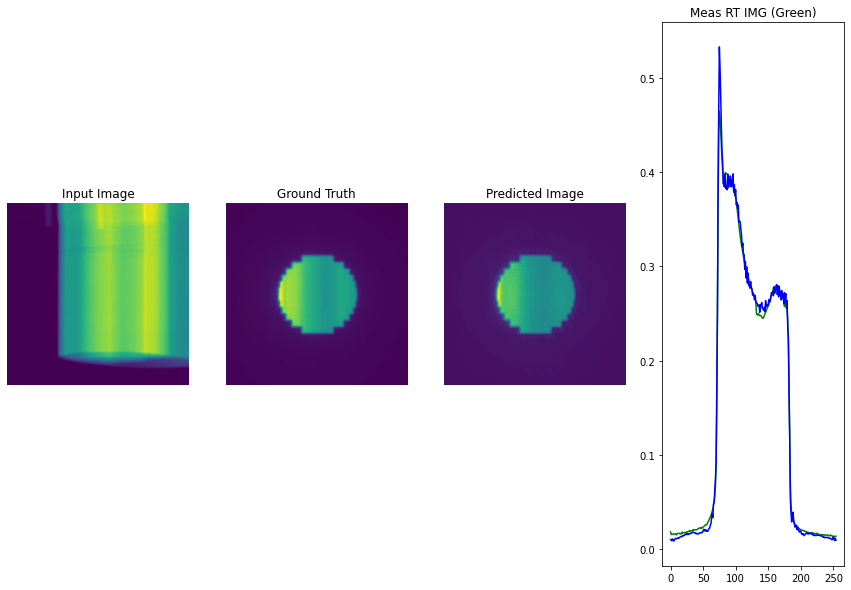

In [52]:
x,y = next(val_iterator)
pred = model.predict(x)
plot_images(pred, x, y)

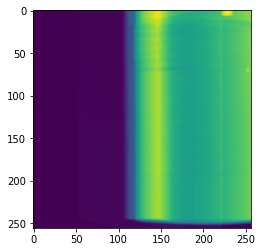

In [33]:
plt.imshow(x[0,..., 4])

In [ ]:
x[0, 125, 125, 3]

In [ ]:
generator = Generator(size=3, layers=5, filters_start=32, double_layers=3)
generator.load_weights(r'/content/drive/MyDrive/Colab Notebooks/logs/layers5_kernel3_filters32_lr0.00101_Relu_60k/final_model.h5')

## Define the optimizers and a checkpoint-saver


In [ ]:
#docs_infra: no_execute'
%reload_ext tensorboard
#%tensorboard --logdir /content/notebooks/logs/fit/

In [ ]:
logdir = '/content/drive/MyDrive/Colab Notebooks/logs/'

In [ ]:
%tensorboard --logdir '/content/drive/MyDrive/Colab Notebooks/logs/'

If you want to share the TensorBoard results _publicly_, you can upload the logs to [TensorBoard.dev](https://tensorboard.dev/) by copying the following into a code-cell.

Note: This requires a Google account.

```
!tensorboard dev upload --logdir {log_dir}
```

Caution: This command does not terminate. It's designed to continuously upload the results of long-running experiments. Once your data is uploaded you need to stop it using the "interrupt execution" option in your notebook tool.

You can view the [results of a previous run](https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw) of this notebook on [TensorBoard.dev](https://tensorboard.dev/).

TensorBoard.dev is a managed experience for hosting, tracking, and sharing ML experiments with everyone.

It can also included inline using an `<iframe>`:

Interpreting the logs is more subtle when training a GAN (or a cGAN like pix2pix) compared to a simple classification or regression model. Things to look for:

- Check that neither the generator nor the discriminator model has "won". If either the `gen_gan_loss` or the `disc_loss` gets very low, it's an indicator that this model is dominating the other, and you are not successfully training the combined model.
- The value `log(2) = 0.69` is a good reference point for these losses, as it indicates a perplexity of 2 - the discriminator is, on average, equally uncertain about the two options.
- For the `disc_loss`, a value below `0.69` means the discriminator is doing better than random on the combined set of real and generated images.
- For the `gen_gan_loss`, a value below `0.69` means the generator is doing better than random at fooling the discriminator.
- As training progresses, the `gen_l1_loss` should go down.

## Restore the latest checkpoint and test the network

## Generate some images using the test set

In [53]:
gamma_options = {
    'dose_percent_threshold': 3,  # Try with 2%/2mm 
    'distance_mm_threshold': 3,
    'lower_percent_dose_cutoff': 10,
    'interp_fraction': 20,  # Should be 10 or more, see the paper referenced above
    'max_gamma': 2,
    'random_subset': None,  # Can be used to get quick pass rates
    'local_gamma': False,  # Change to false for global gamma
    'ram_available': 2**29  # 1/2 GB
}

In [54]:
xepidmin = -256
xepidmax = 256
yepidmin = -256
yepidmax = 256
grid = 2.0
xepid = np.arange(xepidmin,xepidmax,grid)
yepid = np.arange(yepidmin,yepidmax,grid)
coords = (yepid,xepid)

In [ ]:
# testfiles = tf.io.gfile.glob('/content/drive/My Drive/train/nifti/fold4/12_4_35.*')
# valid_data = load_data(testfiles, tf.estimator.ModeKeys.TRAIN, '/content/drive/My Drive/train/nifti/fold1')

# valid_dataset = tf.data.Dataset.from_tensor_slices((valid_data))
# valid_dataset = valid_dataset.batch(BATCH_SIZE)
val_iterator = iter(valid_dataset)

In [ ]:
np.mean(input[...,1])

Calcing using global normalisation point for gamma
Global normalisation set to 0.2925766110420227
Global dose threshold set to [0.0087773] ([3]% of normalisation)
Distance threshold set to [3]
Lower dose cutoff set to 0.029257661104202273 (10% of normalisation)

Current distance: 4.65 mm | Number of reference points remaining: 2 | Points tested per reference point: 196 | RAM split count: 1
Complete!


Text(0.5, 1.0, 'Local Gamma (3%/3mm) | Percent Pass: 97.58 %')

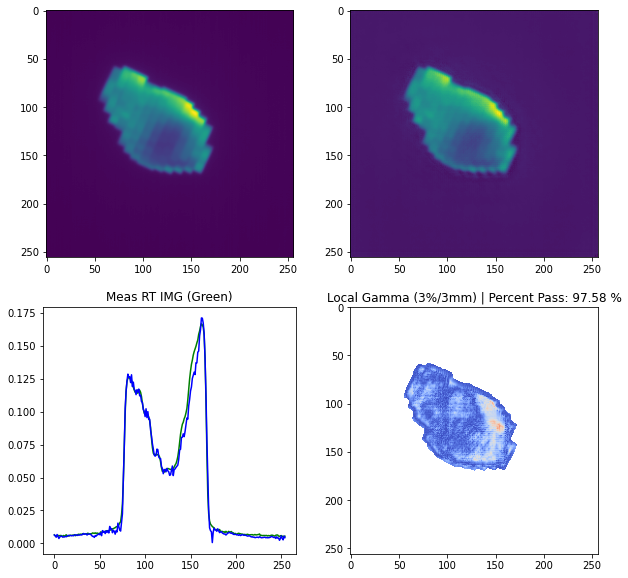

In [58]:
x, y = next(val_iterator)
prediction = tf.squeeze(model.predict(x) )

diff = tf.subtract(y,prediction)
diff = tf.squeeze(diff, axis=0)
diffvec = diff[120,1:256]
plt.figure(figsize=(10, 10))
  
plt.subplot(2, 2, 1)
plt.imshow(tf.squeeze(y))
plt.subplot(2, 2, 2)
plt.imshow(tf.squeeze(prediction))
  
predvec = prediction[128,1:256]
rtvec = tf.squeeze(y)[128,1:256]
  
#predvec = prediction[1:256,128]
#rtvec = rtimage[1:256,128]

plt.subplot(2, 2, 3)
plt.plot(rtvec,'g')
plt.title("Meas RT IMG (Green)")
plt.plot(predvec,'b')
#print(str(example["fname"]))

gamma_test = pymedphys.gamma(coords,tf.squeeze(y), coords, prediction, **gamma_options)
valid_gamma = gamma_test[~np.isnan(gamma_test)]

num_bins = (
    gamma_options['interp_fraction'] * gamma_options['max_gamma'])
bins = np.linspace(0, gamma_options['max_gamma'], num_bins + 1)

#gamma_no_noise = pymedphys.gamma(coords, rtimage, coords, prediction,**gamma_options)
plt.subplot(2, 2, 4)

plt.imshow( gamma_test, clim=(0, 2), cmap='coolwarm')

# plt.hist(valid_gamma, bins, density=True)
# plt.xlim([0, gamma_options['max_gamma']])
pass_ratio = np.sum(valid_gamma <= 1) / len(valid_gamma)
plt.title(f"Local Gamma ({gamma_options['dose_percent_threshold']}%/{gamma_options['distance_mm_threshold']}mm) | Percent Pass: {pass_ratio*100:.2f} %")

In [ ]:
np.max(x[0][...,0].numpy())

In [ ]:
np.exp(-input[0, 128, 128, 1])*input[0, 128, 128, 0]/3.65

In [ ]:
input[0, 128, 128, 1]

In [ ]:
tar[128, 128]

In [ ]:
prediction[128, 128]

In [ ]:
caxcb = [] 
caxrt = []
caxpred = []
caxhalf = []

all_ratios = np.zeros(len(list(valid_dataset)))

for example in valid_dataset:
  tinp = example[0]
  ttar = example[1]
  inp = tf.squeeze(tinp,axis=0)
  #slicen = 1
  pdos = inp[..., 0]
  img = inp[..., 1]
  half = inp[..., 2]
  s, ss = 118, 138
  cbctcax = np.mean(img[s:ss, s:ss] )
  pdoscax = np.mean(pdos[s:ss, s:ss] )
  halfcax = np.mean(half[s:ss, s:ss])
  ttar = tf.squeeze(ttar, axis=0)
  ttar = tf.squeeze(ttar, axis=-1)
  rtimage = ttar
  rtcax = np.mean(ttar[s:ss,s:ss])
  
  #out = "cbctcax {} rtcax {}".format(cbctcax,rtcax/pdoscax)
  #print(out)
  # cbctcax -= (np.sum(inp[...,0].numpy()>.3) * 0.000005)
  #cbctcax = np.exp(-cbctcax) - (np.sum(inp[...,0].numpy()>.3) * 0.000005)
  caxcb = np.append(caxcb,cbctcax)
  caxrt = np.append(caxrt,rtcax/pdoscax)
  caxhalf = np.append(caxhalf,halfcax)

  prediction = model.predict(tinp)
  prediction = tf.squeeze(prediction, axis=0)
  prediction = tf.squeeze(prediction, axis=-1)
  predcax = np.mean(prediction[s:ss,s:ss])
  caxpred = np.append(caxpred,predcax/pdoscax)

#ax = plt.axes(projection='3d')
#ax.scatter3D(caxcb, caxhalf, caxrt, c='b' )
#ax.scatter3D(caxcb, caxhalf, caxpred, c='r' )
#plt.show()

plt.plot(caxcb,caxrt,'bo')
plt.plot(caxcb,caxpred,'ro')

#plt.plot(caxhalf,caxrt,'bo')
#plt.plot(caxhalf,caxpred,'ro')
plt.ylim([0, 0.8])
#plt.xlim([0.80, 0.85])
plt.show()

In [ ]:
from tqdm import tqdm

In [ ]:
all_ratios = np.zeros(len(list(valid_dataset)))
pbar = tqdm(total=len(valid_dataset), desc='Running gamma analysis...')
i = 0
for example in valid_dataset:
  tinp = example[0]
  ttar = example[1]
  prediction = model.predict(tinp)
  ttar = tf.squeeze(ttar, axis=0)
  ttar = tf.squeeze(ttar, axis=-1)
  rtimage = ttar

  prediction = tf.squeeze(prediction, axis=0)
  prediction = tf.squeeze(prediction, axis=-1)
  prediction = prediction 
  gamma_test = pymedphys.gamma(coords,rtimage, coords, prediction, **gamma_options,quiet=True)
  valid_gamma = gamma_test[~np.isnan(gamma_test)]
  pass_ratio = np.sum(valid_gamma <= 1) / len(valid_gamma)
  #tf.print(example["fname"])
  print(pass_ratio)
  all_ratios[i] = pass_ratio
  i += 1
  pbar.update()

print("mean " + str(np.mean(all_ratios)))
print("STD " + str(np.std(all_ratios)))
print("max " + str(np.max(all_ratios)))
print("min " + str(np.min(all_ratios)))
plt.hist(all_ratios)